In [1]:
#! wget https://data.virginia.gov/dataset/de833a43-7019-444c-8384-9e0cf5255140/resource/60506bbb-685f-4360-8a8c-30e137ce3615/download/community-policing-data.csv

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv("community-policing-data.csv", on_bad_lines="skip")
terry_stops = data[data["REASON FOR STOP"] == "Terry Stop"]

C:\Users\sophi\AppData\Local\Temp\ipykernel_9376\4050143798.py:1: DtypeWarning: Columns (13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("community-policing-data.csv", on_bad_lines="skip")


In [4]:
# replace - with NaN
feature_list = ["FORCE USED BY SUBJECT", "FORCE USED BY OFFICER", "VEHICLE SEARCHED", "PERSON SEARCHED", "ENGLISH SPEAKING"]
for feature in feature_list:
  terry_stops[feature].replace('-', np.nan, inplace= True)


C:\Users\sophi\AppData\Local\Temp\ipykernel_9376\3029540058.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  terry_stops[feature].replace('-', np.nan, inplace= True)
C:\Users\sophi\AppData\Local\Temp\ipykernel_9376\3029540058.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terry_stops[feature].replace('-', np.nan, inplace= True)


In [5]:
# removing all the columns with all null values
terry_stops = terry_stops.drop(columns = ["VIOLATION TYPE", "ADDITIONAL ARREST", "VIRGINIA CRIME CODE"])

# the features without null values are:
# stop date, agency name, jurisdiction, reason for stop, person type, race, ethnicity, age, gender, action taken, residency

In [6]:
# I am going to remove reason for stop because they are all the same
terry_stops = terry_stops.drop(columns = ["REASON FOR STOP"])

# I am going to remove this for the clustering because it is not helpful
# We can later do it by month or year if we are intrested but not for now
terry_stops = terry_stops.drop(columns = ["STOP_DATE"])


# I am dropping these because I think jurisdiction cover the same info, but its less grandular so might led to fewer generalizations
terry_stops = terry_stops.drop(columns = ["AGENCY NAME",	"LOCATION"])

In [43]:
terry_stops = terry_stops[terry_stops['FORCE USED BY OFFICER'].notna()]
terry_stops['FORCE USED BY OFFICER'].replace('Y', 1, inplace= True)
terry_stops['FORCE USED BY OFFICER'].replace('N', 0, inplace=True)

full_df = terry_stops.drop(['JURISDICTION', 'ACTION TAKEN'], axis=1)
Y = terry_stops['FORCE USED BY OFFICER']
X = terry_stops.drop(['FORCE USED BY OFFICER', 'JURISDICTION', 'ACTION TAKEN'], axis=1)

C:\Users\sophi\AppData\Local\Temp\ipykernel_9376\1921141417.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  terry_stops['FORCE USED BY OFFICER'].replace('Y', 1, inplace= True)
C:\Users\sophi\AppData\Local\Temp\ipykernel_9376\1921141417.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

In [45]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
    ])


num_attribs = list(X.select_dtypes(include=[np.number]))
# These are the categorical values that I thought would be most useful
#cat_few = ["PERSON TYPE","RACE","ETHNICITY", "GENDER", "RESIDENCY", "ACTION TAKEN"]
cat_few = ["PERSON TYPE","RACE","ETHNICITY", "GENDER", "RESIDENCY"]
cat_binary = ["PERSON SEARCHED","VEHICLE SEARCHED",	"FORCE USED BY SUBJECT", "ENGLISH SPEAKING"]
encoder = LabelEncoder()

def binary_map(X):
    return np.where(X == "Y", 1, 0)
binary_encoder = FunctionTransformer(binary_map)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("binary", binary_encoder, cat_binary),
        ("cat_few", OneHotEncoder(handle_unknown='ignore'), cat_few),
    ])

X = full_pipeline.fit_transform(X)
feature_names = (
    list(num_attribs) +
    list(cat_binary) +
    list(full_pipeline.named_transformers_["cat_few"].get_feature_names_out(cat_few))
)
print(feature_names)

print(X.shape)

['PERSON SEARCHED', 'VEHICLE SEARCHED', 'FORCE USED BY SUBJECT', 'ENGLISH SPEAKING', 'PERSON TYPE_Driver', 'PERSON TYPE_Missing', 'PERSON TYPE_Other Individual', 'PERSON TYPE_Passenger', 'RACE_American Indian or Alaska Native', 'RACE_Asian or Native Hawaiian or Other Pacific Islander', 'RACE_Black or African American', 'RACE_Missing', 'RACE_Unknown', 'RACE_White', 'ETHNICITY_Hispanic or Latino', 'ETHNICITY_Non-Hispanic or Latino', 'ETHNICITY_Unknown', 'GENDER_Female', 'GENDER_Male', 'GENDER_Missing', 'GENDER_Other', 'GENDER_Unknown', 'RESIDENCY_Missing', 'RESIDENCY_Other Virginia jurisdiction resident', 'RESIDENCY_Out of State resident', 'RESIDENCY_Resident of city/county of stop', 'RESIDENCY_Unknown']
(30858, 27)


# Predicting whether force is used

## Using all characteristics for now except jurisdiction

In [36]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_recall_curve, recall_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# URL: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
# Description: Used that source to figure out how to format seaborn confusion matrix heatmap with more class labels and percentages.
def plot_cnf(cnf):
    group_names = ['TN', 'FP', 'FN', 'TP']
    group_counts = ["{0:0.0f}".format(value) for value in cnf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cnf.flatten()/np.sum(cnf)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cnf, annot=labels, fmt='', cmap='RdPu')

### Random Forest

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6087
           1       0.75      0.51      0.61        85

    accuracy                           0.99      6172
   macro avg       0.87      0.75      0.80      6172
weighted avg       0.99      0.99      0.99      6172



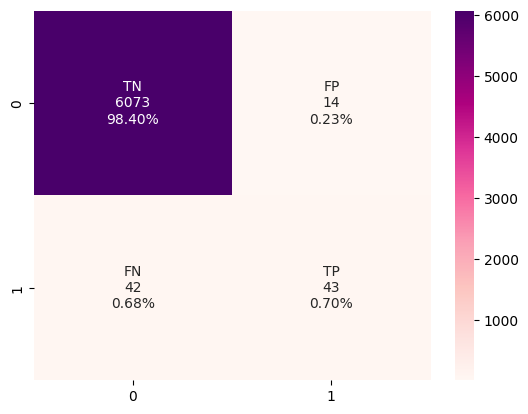

In [47]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_pred=y_pred_rf, y_true=y_test))
cnf_rf = confusion_matrix(y_pred=y_pred_rf, y_true=y_test)
plot_cnf(cnf_rf)

### Resampling to undersample the negative class

In [48]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X,Y)
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X_resampled, y_resampled)

              precision    recall  f1-score   support

           0       0.87      0.77      0.82       122
           1       0.77      0.87      0.82       110

    accuracy                           0.82       232
   macro avg       0.82      0.82      0.82       232
weighted avg       0.82      0.82      0.82       232



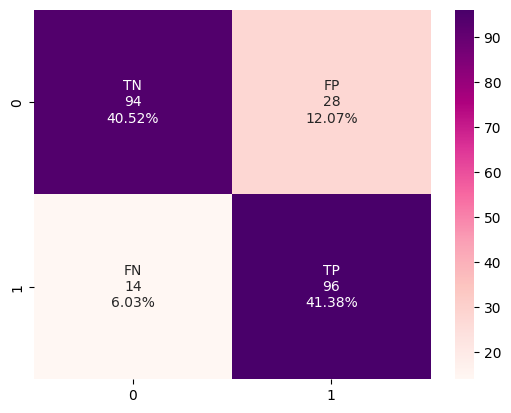

In [49]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_rs, y_train_rs)
y_pred_rf = rf.predict(X_test_rs)
print(classification_report(y_pred=y_pred_rf, y_true=y_test_rs))
cnf_rf = confusion_matrix(y_pred=y_pred_rf, y_true=y_test_rs)
plot_cnf(cnf_rf)

Plotting feature importance

C:\Users\sophi\AppData\Local\Temp\ipykernel_9376\3965787650.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


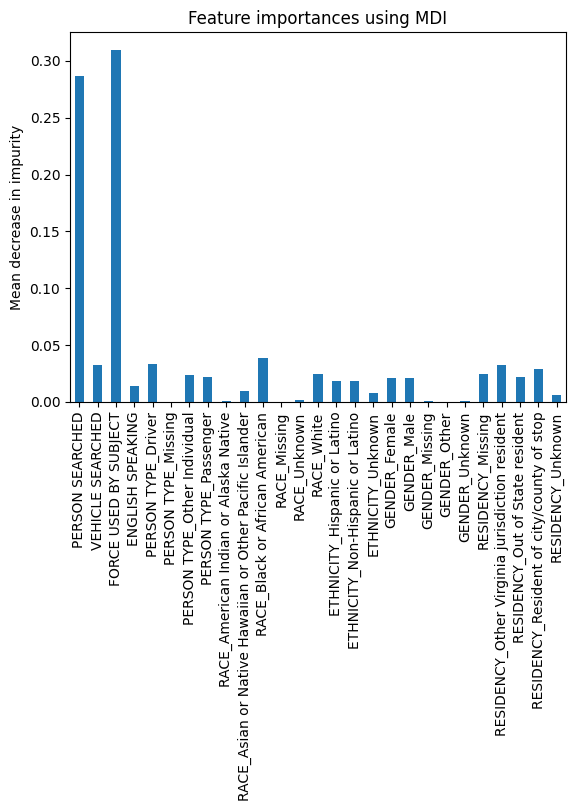

<Figure size 12800x12800 with 0 Axes>

In [ ]:
# URL: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# Description: Used this documentation to plot feature importance.
rf_importances = rf.feature_importances_
rf_importances = pd.Series(rf_importances, index=feature_names)
std = np.std([rf.feature_importances_ for tree in rf.estimators_], axis=0)
fig, ax = plt.subplots()
rf_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.figure(figsize=(128,128))
fig.show()